In [2]:
import sys
sys.version

'3.8.6 (default, Oct  8 2020, 14:06:32) \n[Clang 12.0.0 (clang-1200.0.32.2)]'

In [3]:
import json

from matplotlib import pyplot as plt
import pandas as pd

pd.set_option('max_columns', 0)

def set_colors(fg='w', bg='#222'):
    plt.rcParams.update({
        'xtick.color': fg,
        'ytick.color': fg,
        'text.color': fg,
        'axes.labelcolor': fg,
        'axes.edgecolor': fg,
        'axes.facecolor': bg,
        'figure.facecolor': bg,
    })
set_colors()

## new output

In [11]:
# -> 10x smaller without confirmed (2.7M)
# ->  7x smaller with    confirmed (3.4M)
# -> 25x smaller with    new, d*   (935k)
!ls -lh ../output/table.json
!ls -lh ../output/info.json
with open('../output/table.json') as f:
    table = json.load(f)
with open('../output/info.json') as f:
    info = json.load(f)

-rw-r--r--  1 ast  staff   935K Oct 12 22:24 ../output/table.json
-rw-r--r--  1 ast  staff    19K Oct 12 22:24 ../output/info.json


In [8]:
def fillnarows(table):
    return [row if row is not None else [None] * 3 for row in table]
pd.DataFrame(fillnarows(table[-1]), index=info['rows'], columns=info['cols'])

,new,drecovered,ddeaths
Afghanistan,39530.0,32926.0,1466.0
Albania,0.0,0.0,0.0
Algeria,37709.0,27764.0,1379.0
Andorra,0.0,0.0,0.0
Angola,3550.0,902.0,163.0
...,...,...,...
Western Sahara,0.0,0.0,0.0
World,37140605.0,25820468.0,1070833.0
Yemen,2041.0,1321.0,594.0
Zambia,13364.0,13212.0,0.0


In [9]:
df = pd.DataFrame(
    [row for _ in map(fillnarows, table) for row in _],
    index=pd.MultiIndex.from_product((info['dates'], info['rows'])),
    columns=info['cols'],
)
df.index = df.index.set_names(('date', 'country'))
print(df.values.shape)
df.head()

(2781, 3)


new  drecovered  ddeaths
date       country                                  
2020-10-02 Afghanistan  39290.0     32842.0   1458.0
           Albania          0.0         0.0      0.0
           Algeria      37882.0     28043.0   1360.0
           Andorra          0.0         0.0      0.0
           Angola        3101.0       675.0    136.0

In [10]:
df.loc[(slice(info['dates'][0], info['dates'][-1]), 'Afghanistan'), :]
df.loc[(slice(None), 'Afghanistan'), :]
idx = pd.IndexSlice
df.loc[idx[:, 'Afghanistan'], :]

,,new,drecovered,ddeaths
date,country,,,
2020-10-02,Afghanistan,39290.0,32842.0,1458.0
2020-10-03,Afghanistan,39112.0,32842.0,1459.0
2020-10-04,Afghanistan,31014.0,32852.0,1314.0
2020-10-05,Afghanistan,30895.0,32879.0,1318.0
2020-10-06,Afghanistan,39335.0,32843.0,1460.0
2020-10-07,Afghanistan,39397.0,32911.0,1462.0
2020-10-08,Afghanistan,39451.0,32923.0,1463.0
2020-10-09,Afghanistan,39526.0,32921.0,1465.0
2020-10-10,Afghanistan,39530.0,32926.0,1466.0


In [142]:
df.xs('Afghanistan', level=1)  # drop_level=True

,new,recovered,deaths
date,,,
2020-01-22,NaN,NaN,NaN
2020-01-23,NaN,NaN,NaN
2020-01-24,NaN,NaN,NaN
2020-01-25,NaN,NaN,NaN
2020-01-26,NaN,NaN,NaN
...,...,...,...
2020-10-05,81.0,32879.0,1466.0
2020-10-06,64.0,32977.0,1467.0
2020-10-07,62.0,33045.0,1469.0


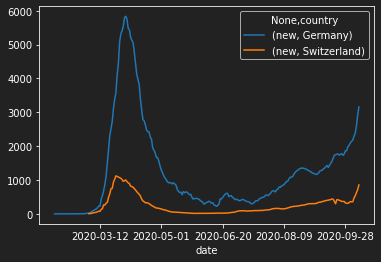

In [151]:
df.unstack().rolling(7).mean().loc[:, idx['new', ('Switzerland', 'Germany')]].plot();

## old output

In [75]:
path = '../output/bydate.json'
bydate = json.load(open(path))
!ls -lh $path
len(bydate)

-rw-r--r--  1 ast  staff    25M Oct 10 09:13 ../output/bydate.json


262

In [76]:
# level: country, state, county (not currently)
row = bydate[-1]
data = row['data']
row.keys(), row['date'], list(data.keys())[0], data['Afghanistan']

(dict_keys(['date', 'data']),
 '2020-10-09',
 'Afghanistan',
 {'level': 'country',
  'confirmed': 39693,
  'deaths': 1472,
  'recovered': 33058,
  'active': 5163,
  'pop': 38928341,
  'new': 77})

In [96]:
def get_country(country):
    return pd.DataFrame([
        dict(date=row['date'], **row['data'][country])
        for row in bydate if country in row['data']
    ]).set_index('date')
country = get_country('Afghanistan')

In [97]:
# so confirmed is basically == cumsum(new)
(country.confirmed - country.new.cumsum()).value_counts()

1.0    228
dtype: int64

In [99]:
# so recovered is basically == confirmed - deaths - active
(country.confirmed - country.deaths - country.active - country.recovered).value_counts()

0     202
1      13
21      3
7       3
23      2
4       2
20      1
16      1
11      1
5       1
dtype: int64

In [77]:
keys = pd.DataFrame(({
    'key': key,
    'key0': key.split(',')[0] if ',' in key else None,
    'level': value['level']
} for key, value in data.items()))
keys.level.value_counts()

state      575
country    187
i18n         1
Name: level, dtype: int64

In [78]:
keys.key0.value_counts()

Russia            83
US                58
Japan             49
India             37
Colombia          34
China             33
Mexico            32
Ukraine           27
Brazil            27
Peru              26
Italy             21
Sweden            21
Spain             20
Chile             17
Netherlands       17
Germany           17
United Kingdom    15
Canada            14
France            10
Australia          8
Pakistan           7
Denmark            2
Name: key0, dtype: int64

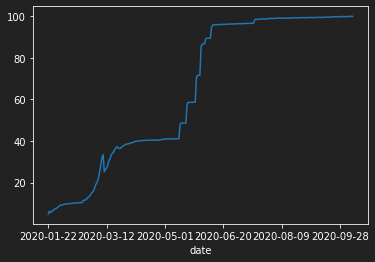

In [79]:
sizes = pd.DataFrame(({'date': _['date'], 'kb_per_day': len(json.dumps(_['data']))/1024} for _ in bydate))
sizes.set_index('date').kb_per_day.plot();

In [80]:
bydate_countries = [
    dict(
        date=row['date'],
        data={
            k: v
            for k, v in row['data'].items()
            if v['level'] == 'country'
        }
    )
    for row in bydate
]
len(json.dumps(bydate_countries)) / len(json.dumps(bydate))

0.3048836727665223

## covid_19 : CH data

In [186]:
df = pd.read_csv('covid_19/COVID19_Fallzahlen_CH_total_v2.csv')
print(len(df))
df.tail()

5461


,date,time,abbreviation_canton_and_fl,ncumul_tested,ncumul_conf,new_hosp,current_hosp,current_icu,current_vent,ncumul_released,ncumul_deceased,source,current_isolated,current_quarantined,ncumul_confirmed_non_resident,current_hosp_non_resident,current_quarantined_riskareatravel,current_quarantined_total,current_hosp_resident
5456,2020-10-10,08:30,BS,NaN,1412.0,NaN,NaN,NaN,NaN,1264.0,54.0,https://www.gesundheit.bs.ch,94.0,257.0,NaN,NaN,NaN,NaN,NaN
5457,2020-10-10,09:00,SZ,NaN,880.0,NaN,NaN,NaN,NaN,555.0,25.0,https://www.sz.ch/public/upload/assets/49056/C...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5458,2020-10-11,NaN,FL,NaN,144.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.regierung.li/media/attachments/560...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5459,2020-10-11,08:00,BE,NaN,4352.0,NaN,NaN,NaN,NaN,NaN,104.0,https://www.besondere-lage.sites.be.ch/besonde...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5460,2020-10-11,08:30,BS,NaN,1428.0,NaN,NaN,NaN,NaN,1274.0,54.0,https://www.gesundheit.bs.ch,100.0,280.0,NaN,NaN,NaN,NaN,NaN


In [159]:
ddf = df.set_index(['date', 'abbreviation_canton_and_fl']).loc[
    :, ['ncumul_conf', 'ncumul_deceased', 'ncumul_released']].rename(
    columns=dict(ncumul_conf='confirmed', ncumul_deceased='deaths', ncumul_released='recovered')
)
ddf.unstack().tail()

confirmed                       ... recovered                  
abbreviation_canton_and_fl        AG    AI     AR      BE  ...        VD     VS     ZG  ZH
date                                                       ...                            
2020-10-05                    2712.0  43.0  197.0  3759.0  ...       NaN  328.0  421.0 NaN
2020-10-06                    2755.0  43.0    NaN  3824.0  ...       NaN  331.0  421.0 NaN
2020-10-07                    2810.0  44.0    NaN  3908.0  ...       NaN  331.0  421.0 NaN
2020-10-08                    2868.0  47.0  214.0  4006.0  ...       NaN  331.0  428.0 NaN
2020-10-09                       NaN  52.0  218.0  4105.0  ...       NaN    NaN  433.0 NaN

[5 rows x 81 columns]

In [161]:
# "recovered" often missing, unfortunately ...
ddf.recovered.unstack()

abbreviation_canton_and_fl,AG,AI,AR,BE,BL,BS,FL,FR,GE,GL,GR,JU,LU,NE,NW,OW,SG,SH,SO,SZ,TG,TI,UR,VD,VS,ZG,ZH
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-05,2455.0,NaN,NaN,NaN,1127.0,1247.0,116.0,176.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,538.0,88.0,932.0,134.0,NaN,328.0,421.0,NaN
2020-10-06,2480.0,NaN,NaN,NaN,1131.0,1248.0,116.0,177.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,542.0,90.0,932.0,134.0,NaN,331.0,421.0,NaN
2020-10-07,2495.0,NaN,NaN,NaN,1132.0,1253.0,117.0,177.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,544.0,90.0,933.0,135.0,NaN,331.0,421.0,NaN


<AxesSubplot:xlabel='date,abbreviation_canton_and_fl'>

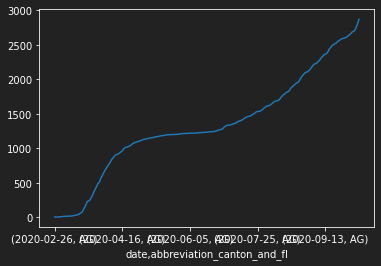

In [160]:
ddf.loc[(slice(None), ('AG',)), 'confirmed'].plot()

In [156]:
print('\n'.join(sorted(df.columns)))

abbreviation_canton_and_fl
current_hosp
current_hosp_non_resident
current_hosp_resident
current_icu
current_isolated
current_quarantined
current_quarantined_riskareatravel
current_quarantined_total
current_vent
date
ncumul_conf
ncumul_confirmed_non_resident
ncumul_deceased
ncumul_released
ncumul_tested
new_hosp
source
time


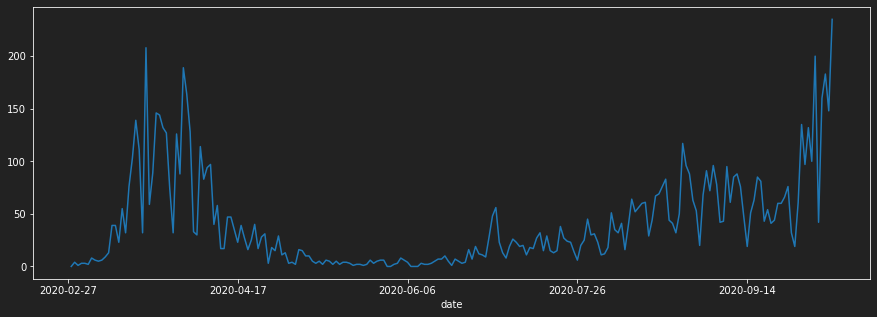

In [82]:
# new ZH cases
plt.figure(figsize=(15, 5))
df[df.abbreviation_canton_and_fl == 'ZH'].set_index('date').ncumul_conf.diff().plot();

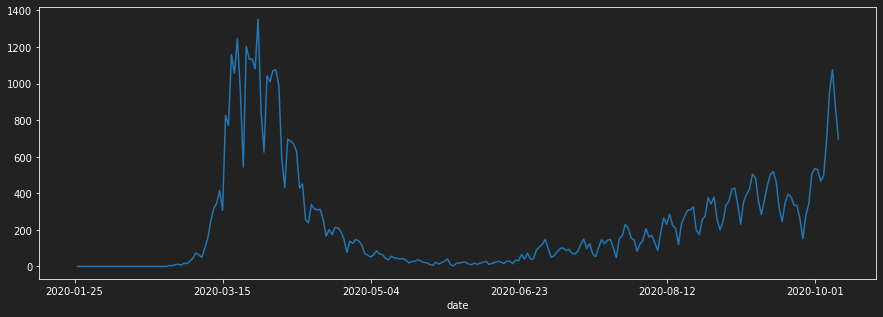

In [83]:
# new CH cases (filled)
plt.figure(figsize=(15, 5))
df.set_index(['date', 'abbreviation_canton_and_fl']).ncumul_conf.unstack().fillna(method='ffill').stack().reset_index().rename(columns={0: 'ncumul_conf'}).groupby('date').ncumul_conf.sum().diff().plot();

In [84]:
# latest new cases by canton (filled)
df.set_index(['date', 'abbreviation_canton_and_fl']).ncumul_conf.unstack().fillna(method='ffill').diff().tail(10).astype(int)

abbreviation_canton_and_fl,AG,AI,AR,BE,BL,BS,FL,FR,GE,GL,GR,JU,LU,NE,NW,OW,SG,SH,SO,SZ,TG,TI,UR,VD,VS,ZG,ZH
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-09-30,18,1,9,45,2,5,0,16,60,3,9,1,14,13,2,1,23,4,9,11,9,6,0,79,20,8,135
2020-10-01,16,1,0,52,6,3,1,25,76,2,8,7,8,27,4,0,36,6,10,9,6,5,1,102,22,6,97
2020-10-02,16,1,6,55,5,6,1,24,60,0,14,1,0,13,2,1,33,3,8,9,14,10,3,84,25,3,132
2020-10-03,24,0,0,48,10,13,3,24,68,0,5,7,0,5,2,0,22,0,0,14,11,0,0,95,15,0,100
2020-10-04,10,0,0,65,6,7,3,26,37,0,0,1,0,15,3,0,7,0,0,0,7,0,0,88,19,0,200
2020-10-05,16,1,12,38,3,4,1,11,90,4,7,8,35,43,2,3,75,7,23,26,9,21,5,131,34,35,42
2020-10-06,43,0,0,65,11,6,3,38,134,1,24,22,14,43,10,5,51,3,5,34,25,17,0,155,60,25,160
2020-10-07,55,1,0,84,14,14,1,47,118,1,16,17,21,46,6,13,73,6,24,38,25,39,14,136,58,26,183
2020-10-08,58,3,17,98,13,15,5,50,156,4,22,32,43,0,9,5,29,5,0,56,32,40,2,0,0,28,148


In [85]:
df[df.date == df.date.max()]

,date,time,abbreviation_canton_and_fl,ncumul_tested,ncumul_conf,new_hosp,current_hosp,current_icu,current_vent,ncumul_released,ncumul_deceased,source,current_isolated,current_quarantined,ncumul_confirmed_non_resident,current_hosp_non_resident,current_quarantined_riskareatravel,current_quarantined_total,current_hosp_resident
5419,2020-10-09,NaN,BL,NaN,1266.0,NaN,4.0,1.0,0.0,1135.0,37.0,https://www.baselland.ch/politik-und-behorden/...,76.0,209.0,NaN,NaN,NaN,NaN,NaN
5420,2020-10-09,NaN,FL,NaN,139.0,NaN,1.0,NaN,NaN,117.0,1.0,https://www.llv.li/files/ag/aktuelle-fallzahle...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5421,2020-10-09,NaN,FR,NaN,2743.0,NaN,12.0,2.0,NaN,177.0,102.0,https://www.fr.ch/sites/default/files/2020-10/...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5422,2020-10-09,NaN,GE,NaN,NaN,NaN,48.0,7.0,NaN,NaN,NaN,https://www.ge.ch/document/21502/telecharger,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5423,2020-10-09,NaN,GR,NaN,1217.0,NaN,1.0,0.0,0.0,NaN,50.0,https://services1.arcgis.com/YAuo6vcW85VPu7OE/...,116.0,756.0,NaN,NaN,NaN,NaN,NaN
5424,2020-10-09,NaN,LU,NaN,1400.0,NaN,7.0,2.0,NaN,NaN,24.0,https://gesundheit.lu.ch/themen/Humanmedizin/I...,183.0,259.0,NaN,NaN,NaN,NaN,NaN
5425,2020-10-09,NaN,NW,NaN,195.0,NaN,0.0,0.0,NaN,NaN,4.0,http://www.nw.ch/coronastatistik,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5426,2020-10-09,NaN,SG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://stada.sg.ch/covid/ContactTracing.html,324.0,825.0,NaN,NaN,NaN,NaN,NaN
5427,2020-10-09,00:00,OW,NaN,160.0,NaN,1.0,NaN,NaN,NaN,0.0,https://www.ow.ch/dl.php/de/5f8072155ea23/OW-1...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5428,2020-10-09,08:00,BE,NaN,4105.0,NaN,39.0,7.0,3.0,NaN,104.0,https://www.besondere-lage.sites.be.ch/besonde...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## ZH data

3137 Date,Area,AgeYear,Gender,NewConfCases,NewDeaths,Source latest date 2020-07-08


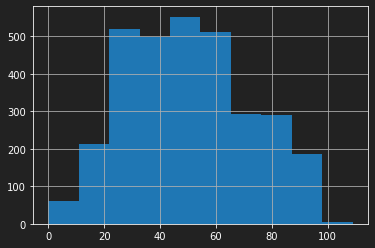

In [184]:
# Unfortunately only until July.
df = pd.read_csv('covid_19/fallzahlen_kanton_alter_geschlecht_csv/COVID19_Fallzahlen_Kanton_ZH_alter_geschlecht.csv')
df.AgeYear.hist()
print(len(df), ','.join(df.columns), 'latest date', df.Date.max())

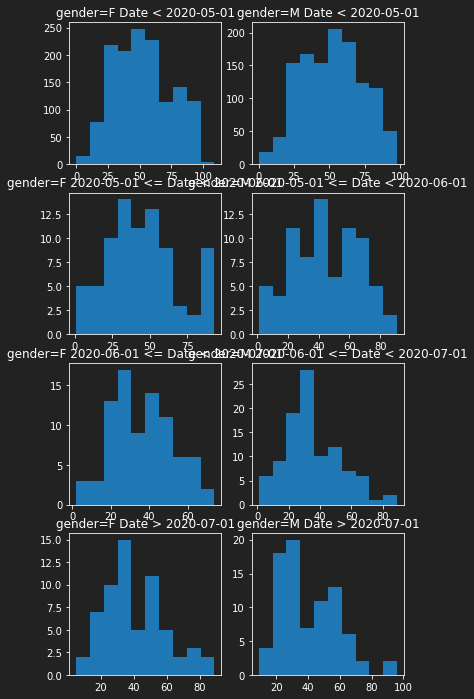

In [185]:
col = 'AgeYear'
# limitcol = 'AgeYear'
# limits = (10, 40, 60)
limitcol = 'Date'
limits = ('2020-05-01', '2020-06-01', '2020-07-01')
_, axs = plt.subplots(len(limits) + 1, 2, figsize=(2 * 3, (len(limits) + 1) * 3))
for y in range(len(limits) + 1):
    for x, gender in enumerate('FM'):
        ax = axs[y][x]
        sel = df.Gender == gender
        title = f'gender={gender} '
        if y == len(limits):
            sel &= df[limitcol] > limits[-1]
            title += f'{limitcol} > {limits[-1]}'
        elif y > 0:
            sel &= (limits[y - 1] <= df[limitcol]) & (df[limitcol] < limits[y])
            title += f'{limits[y - 1]} <= {limitcol} < {limits[y]}'
        else:
            sel &= df[limitcol] < limits[0]
            title += f'{limitcol} < {limits[0]}'
        ax.hist(df.loc[sel, col])
        ax.set_title(title)